<a href="https://colab.research.google.com/github/serinamarie/DS-Unit-2-Applied-Modeling/blob/master/Unit_2_Sprint_3_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [349]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module4')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.1.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd

train_features = pd.read_csv('../data/waterpumps/train_features.csv')
train_labels = pd.read_csv('../data/waterpumps/train_labels.csv')
test_features = pd.read_csv('../data/waterpumps/test_features.csv')
sample_submission = pd.read_csv('../data/waterpumps/sample_submission.csv')

assert train_features.shape == (59400, 40)
assert train_labels.shape == (59400, 2)
assert test_features.shape == (14358, 40)
assert sample_submission.shape == (14358, 2)

In [352]:
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import stats
import category_encoders as ce
from sklearn.metrics import accuracy_score, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

#Separate our features and our target
X_for_split = train_features
y_for_split = train_labels['status_group']

#Split data into train & val data
X_train, X_val, y_train, y_val = train_test_split(
    X_for_split, y_for_split, train_size = 0.9, test_size = 0.1,
    stratify = y_for_split, random_state=8)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((53460, 40), (5940, 40), (53460,), (5940,))

In [0]:
def wrangle(X):
    #Use a combination of wrangle tactics from class and personal wrangling
    X = X.copy()

    #Replace values close to 0 with 0
    X['latitude'] = X['latitude'].replace(-2e-08, 0)

    #Create a column for missing values
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col+'_missing'] = X[col] == 0

    #Convert date_recorded to datetime, then create new columns for each component
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    X['year_recorded'] = X['date_recorded'].dt.year
    X['day_recorded'] = X['date_recorded'].dt.day
    X['month_recorded'] = X['date_recorded'].dt.day
    X['construction_year'] = X['construction_year'].replace(0,1986)
    #Drop redundant columns
    X = X.drop(columns='quantity_group')

    return X

# Wrap our train/test/val feature datasets in this wrangling function
X_train = wrangle(X_train)
X_val = wrangle(X_val)
X_test = wrangle(test_features)


In [0]:
y_train_map = y_train.map({'functional': 1, 'functional needs repair': 0, 'non functional': 0}).astype(str)
y_val_map = y_val.map({'functional': 1, 'functional needs repair': 0, 'non functional': 0}).astype(str)


In [0]:
#Select our features
categorical_features = ['quantity', 'source_class', 'payment', 'source_type', 'management', 'extraction_type', 'quality_group', 'waterpoint_type_group', 'basin', 'lga', 'public_meeting']
numeric_features = ['gps_height_missing', 'amount_tsh', 'gps_height', 'longitude', 'scheme_management', 'year_recorded', 'day_recorded', 'month_recorded', 'population', 'latitude', 'construction_year', 'num_private', 'district_code']
features = categorical_features + numeric_features

#Arrange data into X features matrix and y target vector
X_train_subset = X_train[features]
X_val_subset = X_val[features]

encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X_train_subset)

In [356]:
model = RandomForestClassifier(n_estimators=100, random_state=8, n_jobs=-1)
model.fit(X_encoded, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

##Partial Dependence Plot with Categorical Features

In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [358]:
!pip install pdpbox
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

##Make multiple PDPs with 2 features in interaction

In [0]:
features = ['quantity', 'construction_year']

interaction = pdp_interact(
    model = model,
    dataset = X_encoded,
    model_features = X_encoded.columns,
    features = features)

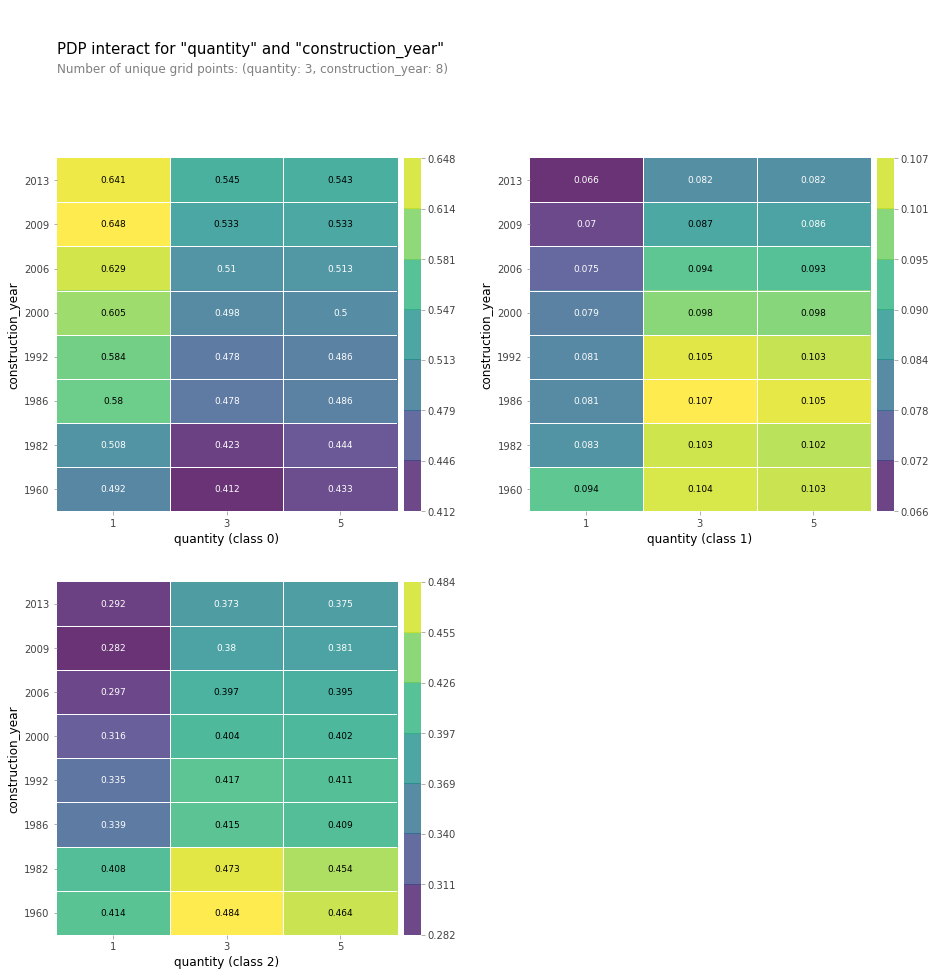

In [360]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [361]:
X_encoded.columns

Index(['quantity', 'source_class', 'payment', 'source_type', 'management',
       'extraction_type', 'quality_group', 'waterpoint_type_group', 'basin',
       'lga', 'public_meeting', 'gps_height_missing', 'amount_tsh',
       'gps_height', 'longitude', 'scheme_management', 'year_recorded',
       'day_recorded', 'month_recorded', 'population', 'latitude',
       'construction_year', 'num_private', 'district_code'],
      dtype='object')

##Make PDP with 1 feature in isolation

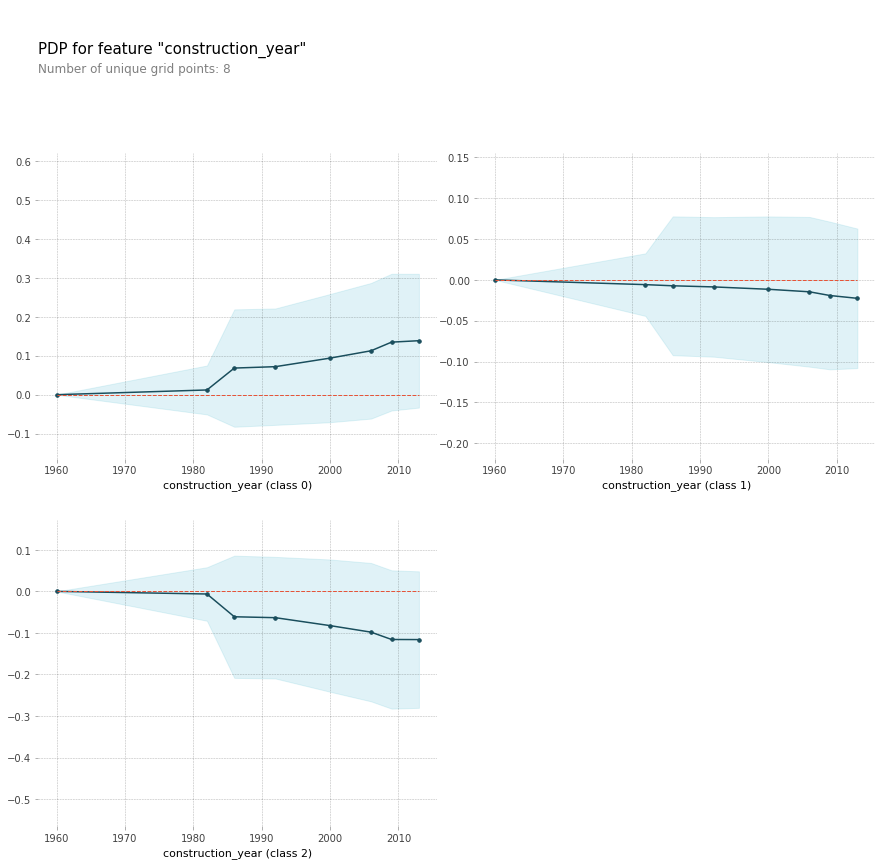

In [362]:
feature = 'construction_year'
isolated = pdp_isolate(
    model = model,
    dataset = X_encoded,
    model_features = X_encoded.columns,
    feature = feature)

pdp_plot(isolated, feature);

##Plot with individual lines for each observation

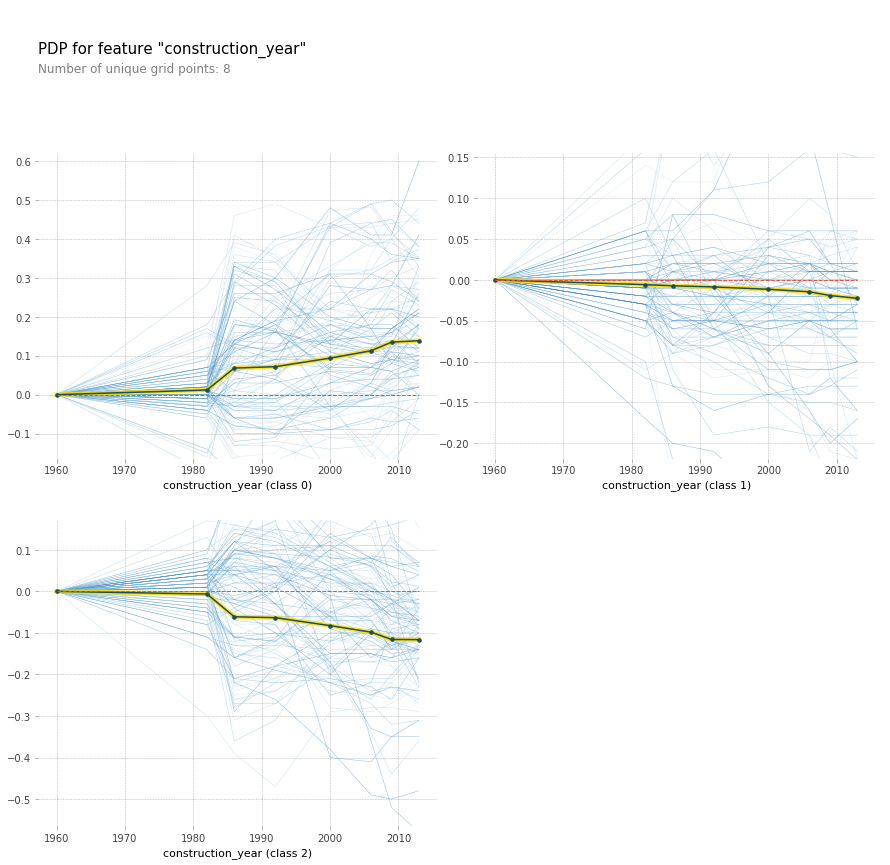

In [363]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100);

In [364]:
grid = isolated.feature_grids
pdp = isolated.pdp

plt.figure(figsize=(10,6))
plt.plot(grid, pdp)
plt.ylim(0,1.1)
plt.xlabel('Construction Year')
plt.ylabel('Status Group')
plt.title('Partial dependence')
plt.show();

AttributeError: ignored

In [0]:
ice = isolated.ice_lines.sample(n=100).T

ice

In [0]:
ice.plot(color='grey', alpha=0.1, legend=False, figsize=(10,6))

plt.plot(grid, pdp)
plt.ylabel('Status Group')
plt.xlabel('Construction Year')
plt.title("Partial Dependence plot");

##PDP visualization with scatter plot... not helpful for classification problem

In [0]:
grid = isolated.feature_grids
pdp = isolated.pdp
y_val_map = y_val_map.astype(int)
merged = X_val.join(y_val_map)

merged.plot.scatter(x='construction_year', y='status_group', 
                 color='grey', alpha=0.05, figsize=(10,6))
plt.plot(grid, pdp, color='r');
#Would be best shown when there is a regression problem and this
#is classification